# Training

This Google Colab notebook trains a model for each subject.

To run successfully you must have the preprocessed Swell dataset in the `dataset` folder as a `pkl` file named `dataset_swell_processed.pkl`.
This file can be recreated by running the `preprocessing.ipynb` notebook.

If you did not run the preprocessing pipeline before a previous copy of this preprocessed dataset is already available from the GitHub repository.

To speed-up training, make sure that you select a Google Colab runtime with a GPU.

In [ ]:
!git clone https://github.com/ggerardlatek/STREDWES-SWELL
%cd STREDWES-SWELL
!pip install -r requirements.txt

In [ ]:
# Check that the code has been cloned
import os

def check_environment_cloned(env_directory):
    return os.path.exists(env_directory)

work_dir = "/content/STREDWES-SWELL"

# Replace 'your_env_directory' with the path to your environment directory
env_cloned = check_environment_cloned(work_dir)
print(f'Environment cloned: {env_cloned}')

In [ ]:
# Setting working dir & data folders paths
os.chdir(work_dir)
print('Work_dir:',work_dir)

input_data_dir = f"{work_dir}/dataset"
results_dir = f"{work_dir}/results"

if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [ ]:
# Importing packages and external functions
from utils.windows import create_windows, split_train_test_val
from utils.GAFGenerator import GAFGenerator
from utils.model import get_model
from packaging import version
import numpy as np
import os
import pickle
import tensorflow as tf
from tensorflow.keras import mixed_precision
from datetime import datetime

#### Review preprocessed dataset


In [ ]:
all_subject_data = pickle.load(open(f'{input_data_dir}/dataset_swell_processed.pkl', 'rb'))
all_subject_data

,index,date_time,id_subject,ECG,EDA,HR,label,HR_proc,variation_label,label_original,RMSSD,SCL,timestamp
0,0,2012-09-18 13:26:00.000000,1,-0.004852,0.222777,-0.154961,0,69,1,N,0.044294,68.212870,0.000000
1,1,2012-09-18 13:26:00.031250,1,-0.077156,0.220309,-0.154221,0,69,0,N,0.044294,68.212870,0.000521
2,2,2012-09-18 13:26:00.062500,1,0.227197,0.225492,-0.153481,0,69,0,N,0.044294,68.212870,0.001042
3,3,2012-09-18 13:26:00.093750,1,0.999998,0.217295,-0.152737,0,69,0,N,0.044294,68.212870,0.001563
4,4,2012-09-18 13:26:00.125000,1,0.292785,0.225934,-0.151814,0,69,0,N,0.044294,68.212870,0.002083
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991035,1991035,2012-11-05 15:09:59.843750,24,0.110750,-0.164577,-0.061232,1,69,0,T,0.053847,200.518946,30.997396
1991036,1991036,2012-11-05 15:09:59.875000,24,-0.011338,-0.165989,-0.061162,1,69,0,T,0.053847,200.518946,30.997917
1991037,1991037,2012-11-05 15:09:59.906250,24,-0.049415,-0.164079,-0.061092,1,69,0,T,0.053847,200.518946,30.998438
1991038,1991038,2012-11-05 15:09:59.937500,24,0.003766,-0.169682,-0.061023,1,69,0,T,0.053847,200.518946,30.998958


In [ ]:
job_start_time = datetime.now().strftime("%d_%m_%Y_%H:%M:%S")
print('Run Started on',job_start_time)

# Hyperparameters
hyp = {
    'batch_size': 8,
    'epochs': 15,
    'freq': 32,
    'image_size': 112,
    'learning_rate': 0.001,
    'optimizer': 'Adam',
    'time_step': 1,  # [sec]
    'window_size': 112,  # [sec]
    'gaf_method': 'difference',
}

In [ ]:
if version.parse(tf.__version__) < version.parse("2.4"):
    policy = mixed_precision.experimental.Policy('mixed_float16')
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)

device = '/device:gpu:0'

batch_size = hyp['batch_size']

enc_labels = {
    'R': 0,
    'N': 0,
    'I': 1,
    'T': 1
}
epochs = hyp['epochs']
features = ['ECG', 'EDA', 'HR']
freq = hyp['freq']
gaf_method = hyp['gaf_method']
image_size = hyp['image_size']
learning_rate = hyp['learning_rate']
n_channels = 3
optimizer = hyp['optimizer']
seed = 42

subjects = all_subject_data['id_subject'].unique()

time_step = round(hyp['time_step'] * hyp['freq'])
window_size = round(hyp['window_size'] * hyp['freq'])

np.random.seed(seed)
tf.random.set_seed(seed)

### Per subject training

In [ ]:
prediction_results = {}

for i, s in enumerate(subjects):
    print(f'Iteration {i} Subject {s}')
    train_windows, test_windows, val_windows = split_train_test_val(
        create_windows([s], all_subject_data, window_size,
        time_step, enc_labels), seed=seed)

    windows_by_split = {
        'train': train_windows,
        'test': test_windows,
        'val': val_windows
    }
    windows_per_sub= {
        'train': len(train_windows),
        'test': len(test_windows),
        'val': len(val_windows)
    }

    #Convert timeseries into images using GAF
    dataset_generators = {split: GAFGenerator(
                                            dataset=all_subject_data,
                                            windows=windows_by_split[split],
                                            features=features,
                                            batch_size=batch_size,
                                            image_size=image_size,
                                            window_size=window_size,
                                            method=gaf_method,
                                            shuffle=True if split=='train' else False,
                                            seed=seed)
                                for split in windows_by_split.keys()}


    with tf.device(device):
        model = get_model(input_dim=(image_size, image_size, n_channels), optimizer=optimizer,
                            learning_rate=learning_rate, n_classes=2, seed=seed, model_name="resnet")

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=4,
                                                verbose=2,
                                                mode='min',
                                                restore_best_weights=True)

        history = model.fit(dataset_generators['train'],
                            epochs=epochs,
                            validation_data=dataset_generators['val'],
                            callbacks=[es],
                            verbose=2)

        scores = model.evaluate(dataset_generators['test'], verbose=2)
        test_loss = scores[0]
        test_accuracy = scores[1]
        print("test_loss:", test_loss)
        print("test_accuracy:", test_accuracy)

        raw_predictions = model.predict(dataset_generators['test'])
        test_predictions = raw_predictions.argmax(axis=1)
        test_labels = dataset_generators['test'].get_labels()
        cm = tf.math.confusion_matrix(
            labels=test_labels, predictions=test_predictions)
        print("Confusion matrix:\n", cm)

        prediction_results[f'S{s}'] = {
            'CM':cm,
            'test_accuracy':test_accuracy,
            'test_loss':test_loss,
            'labels': test_labels,
            'predictions': test_predictions,
            'raw_predictions': raw_predictions,
            'num_windows': windows_per_sub
        }
        tf.keras.backend.clear_session()

#Saving results on Results fold
with open(os.path.join(results_dir, f'prediction_results_{job_start_time}.pkl'), 'wb') as file:
        pickle.dump(prediction_results, file)

job_end_time = datetime.now().strftime("%d_%m_%Y_%H:%M:%S")
print('Run Ended on',job_end_time)


Run Started on 28_09_2023_16:29:25
Arguments Namespace(batch_size=8, enc_labels=None, epochs=15, features=None, freq=32, gaf_method='difference', image_size=112, learning_rate=0.001, n_channels=3, optimizer='Adam', seed=42, subjects=None, time_step=1, window_size=112)
Iteration 0 Subject 1
3416 489 976
{'train': 3416, 'test': 976, 'val': 489}
94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dropout (Dropout)           (None, 64)   

### Show the results

The code below shows the per-subject metrics such as Accuracy, F1 score, precision and recall for the positive class Stress.

The average metrics for all subject are finally computed and a global Confusion Matrix is displayed.

In [67]:
import matplotlib.pyplot as plt
import itertools

In [68]:
# Load Results
prediction_results = pickle.load(open(f'{results_dir}/prediction_results_{job_start_time}.pkl', 'rb'))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


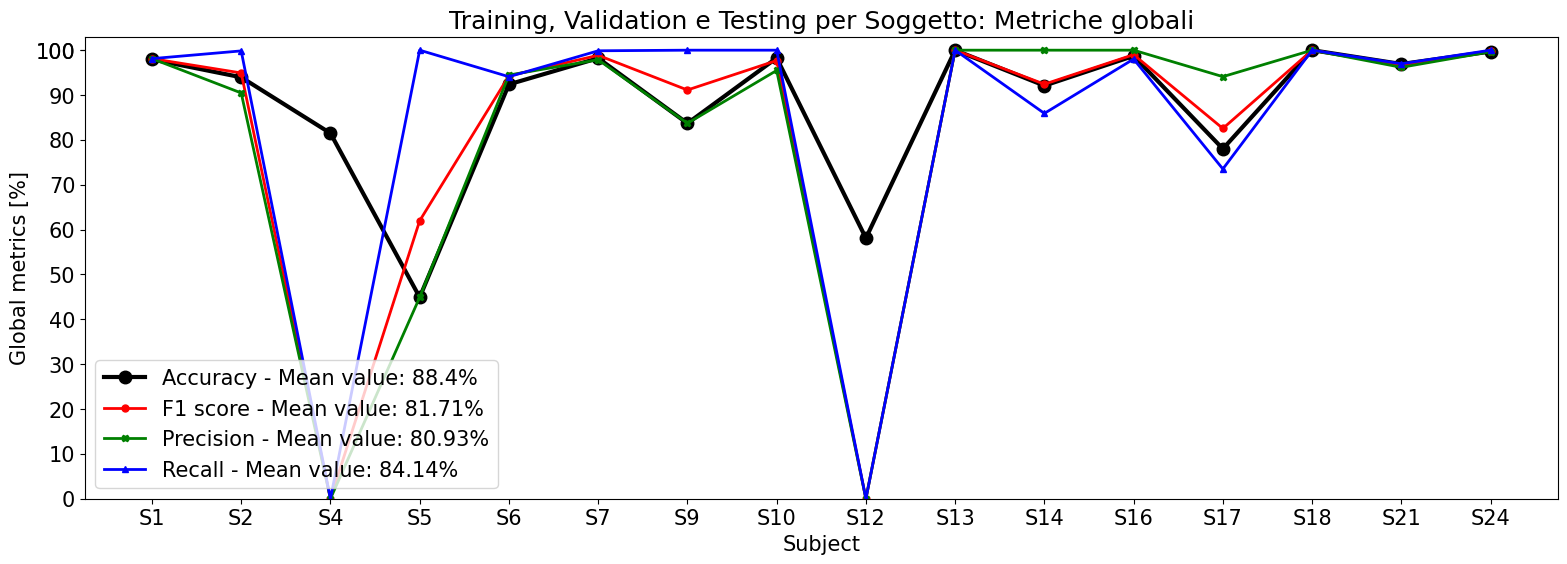

MEAN ACCURACY: 88.4 %
MEAN F1: 81.71 %
MEAN Precision: 80.93 %
MEAN Recall: 84.14 %


In [69]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Precompute the metrics and subjects list
metrics = {
    "Accuracy": [],
    "F1": [],
    "Precision": [],
    "Recall": []
}

for subj, values in prediction_results.items():
    y_true, y_pred = values['labels'], values['predictions']
    metrics["Accuracy"].append(accuracy_score(y_true, y_pred))
    metrics["F1"].append(f1_score(y_true, y_pred))
    metrics["Precision"].append(precision_score(y_true, y_pred))
    metrics["Recall"].append(recall_score(y_true, y_pred))

# Convert the lists to NumPy arrays and scale by 100
metrics = {key: np.array(value) * 100 for key, value in metrics.items()}

# Plotting
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(19,6))
subjs = np.arange(1, len(prediction_results) + 1)

mean_metrics = {key: np.nanmean(value).round(2) for key, value in metrics.items()}

# Iterate through metrics to plot them
markers = iter(['o', 'o', 'X', '^'])
colors = iter(['black', 'r', 'g', 'b'])
for metric, marker, color in zip(metrics.keys(), markers, colors):
    plt.plot(subjs, metrics[metric], '-', marker=marker, linewidth=3 if marker == 'o' else 2,
             markersize=9 if marker == 'o' else 5, color=color, markerfacecolor=color,
             label=f'{metric} - Mean value: {mean_metrics[metric]}%')

plt.title('Per subject metrics on test set')
plt.xlabel('Subject')
plt.ylabel('Global metrics [%]')
plt.xticks(subjs, labels=list(prediction_results.keys()))
plt.legend(loc='lower left')

axes = plt.gca()
axes.set_ylim([30, 103])
axes.yaxis.set_ticks(np.arange(0, 110, 10))
axes.set_xticklabels(list(prediction_results.keys()))
plt.show()

# Print the mean metrics
for metric, mean_value in mean_metrics.items():
    print(f'MEAN {metric}: {mean_value}%')

#### Confusion Matrix (CM) and Normalized CM (per subjects) computation


CM_total_normalized %:
 [[33.86  5.67]
 [ 5.93 54.54]]
Somma:100.0%

Accuracy= 88.0 %
F1score= 90.5 %
Precision= 91.0 %
Recall= 90.0 %


Text(0.5, -31.744106133658896, 'Predicted label')

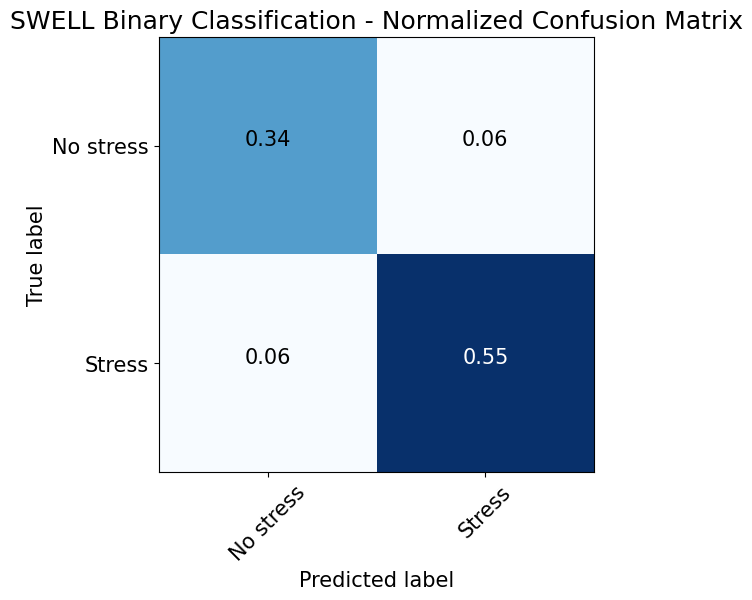

In [70]:
# Function to correct the confusion matrix dimensions
def correct_cm_dims(cm):
    if cm.size == 1:
        return np.array([[cm[0, 0], 0], [0, 0]])
    elif cm.size == 4:
        return cm
    else:
        print(f'Error in metrics shape for subject {subj}')
        return cm  # Or handle the error appropriately

# Get and correct all confusion matrices
CM_subjs = [correct_cm_dims(prediction_results[subj]['CM'].numpy()) for subj in prediction_results]

# Normalize and accumulate confusion matrices
CM_total_normalized = np.sum([cm / np.sum(cm) for cm in CM_subjs], axis=0) / len(CM_subjs)
CM_total_normalized = np.round(CM_total_normalized * 100, 4)

print('CM_total_normalized %:\n', CM_total_normalized)
print('Sum:', np.sum(CM_total_normalized), '%')

# Calculate metrics
tn, fp, fn, tp = CM_total_normalized.reshape(-1)  # Assumes a flattened order of [[0, 1], [2, 3]]
acc = np.round((tp + tn) / (tp + tn + fn + fp), 2) * 100
precision = np.round(tp / (tp + fp), 2) * 100
recall = np.round(tp / (tp + fn), 2) * 100
f1 = np.round(2 * (precision * recall) / (precision + recall), 2)

print('\nAccuracy=', acc, '%')
print('F1score=', f1, '%')
print('Precision=', precision, '%')
print('Recall=', recall, '%')

# Plot normalized confusion matrix
CM_plot = np.round(CM_total_normalized / 100, 2)
cmap = plt.get_cmap('Blues')

plt.figure(figsize=(8, 6))
plt.imshow(CM_plot, interpolation='nearest', cmap=cmap)
plt.title("SWELL Binary Classification - Normalized Confusion Matrix")

target_names = ['No stress', 'Stress']
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

thresh = CM_plot.max() / 1.5
for i, j in itertools.product(range(CM_plot.shape[0]), range(CM_plot.shape[1])):
    plt.text(j, i, "{:,}".format(CM_plot[i, j]), horizontalalignment="center",
             color="white" if CM_plot[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [87]:
import pandas as pd

# Extracting data from prediction_results
data = {
    'Subject': list(prediction_results.keys()),
    'TR-win': [prediction_results[s]['num_windows']['train'] for s in prediction_results],
    'VAL-win': [prediction_results[s]['num_windows']['val'] for s in prediction_results],
    'TEST-win': [prediction_results[s]['num_windows']['test'] for s in prediction_results]
}

# Creating DataFrame
info_win = pd.DataFrame(data)

# Calculating Total windows
info_win['Total windows'] = info_win['TR-win'] + info_win['VAL-win'] + info_win['TEST-win']

# Displaying DataFrame
display(info_win)

,Subject,TR-win,VAL-win,TEST-win,Total windows
0,S1,3416.0,489.0,976.0,4881.0
1,S2,3880.0,555.0,1109.0,5544.0
2,S4,473.0,68.0,135.0,676.0
3,S5,1612.0,231.0,461.0,2304.0
4,S6,2662.0,381.0,761.0,3804.0
5,S7,3334.0,477.0,953.0,4764.0
6,S9,814.0,117.0,233.0,1164.0
7,S10,1607.0,230.0,459.0,2296.0
8,S12,2830.0,405.0,809.0,4044.0
9,S13,1864.0,267.0,533.0,2664.0
